In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
PATH = "./data"
Lead_ACC = pickle.load(open(f"{PATH}/ACC_24.pickle", "rb"))
Lead_RMSD_arr = pickle.load(open(f"{PATH}/RMSE_24.pickle", "rb"))

levels = ["z", "t", "t2m", "u10", "v10"]

list_acc = []
list_rmse = []
lead_time = []
metric = []
for idx, lev in enumerate(levels):
    for i in range(len(Lead_ACC[lev]) - 1):  # car dernière liste tjr vide
        for j in range(len(Lead_ACC[lev][i])):
            acc = Lead_ACC[lev][i][j]
            rmse = Lead_RMSD_arr[lev][i][j]
            if np.isnan(acc):
                continue
            if np.isnan(rmse):
                continue

            list_acc.append(acc)
            list_rmse.append(rmse)
            lead_time.append(i * 6)
            metric.append(lev)
df_acc = pd.DataFrame(
    {
        "acc": list_acc,
        "lead time": lead_time,
        "variable": metric,
    }
)
df_acc["model"] = "ClimODE"
df_rmse = pd.DataFrame(
    {
        "rmse": list_rmse,
        "lead time": lead_time,
        "variable": metric,
    }
)
df_rmse["model"] = "ClimODE"


other_model_acc = pd.read_csv(f"{PATH}/other_model_acc.csv")
df_acc = pd.concat([df_acc, other_model_acc]).reset_index(drop=True)
other_model_rmse = pd.read_csv(f"{PATH}/other_model_rmse.csv")
df_rmse = pd.concat([df_rmse, other_model_rmse]).reset_index(drop=True)

var_list = ["2m_temperature", "temperature", "geopotential", "10m_u_component_of_wind"]
dict_var = {
    "t2m": "2m_temperature",
    "t": "temperature",
    "z": "geopotential",
    "u10": "10m_u_component_of_wind",
}
df_acc = df_acc.replace(dict_var)
df_rmse = df_rmse.replace(dict_var)
df_rmse = df_rmse.drop(index=df_rmse[df_rmse["rmse"] > 1000].index)
df_acc

,acc,lead time,variable,model
0,0.991088,0,geopotential,ClimODE
1,0.990470,0,geopotential,ClimODE
2,0.990147,0,geopotential,ClimODE
3,0.990423,0,geopotential,ClimODE
4,0.991839,0,geopotential,ClimODE
...,...,...,...,...
13752,0.930000,120,temperature,IFS
13753,0.980000,6,10m_u_component_of_wind,IFS
13754,0.970000,24,10m_u_component_of_wind,IFS
13755,0.890000,72,10m_u_component_of_wind,IFS


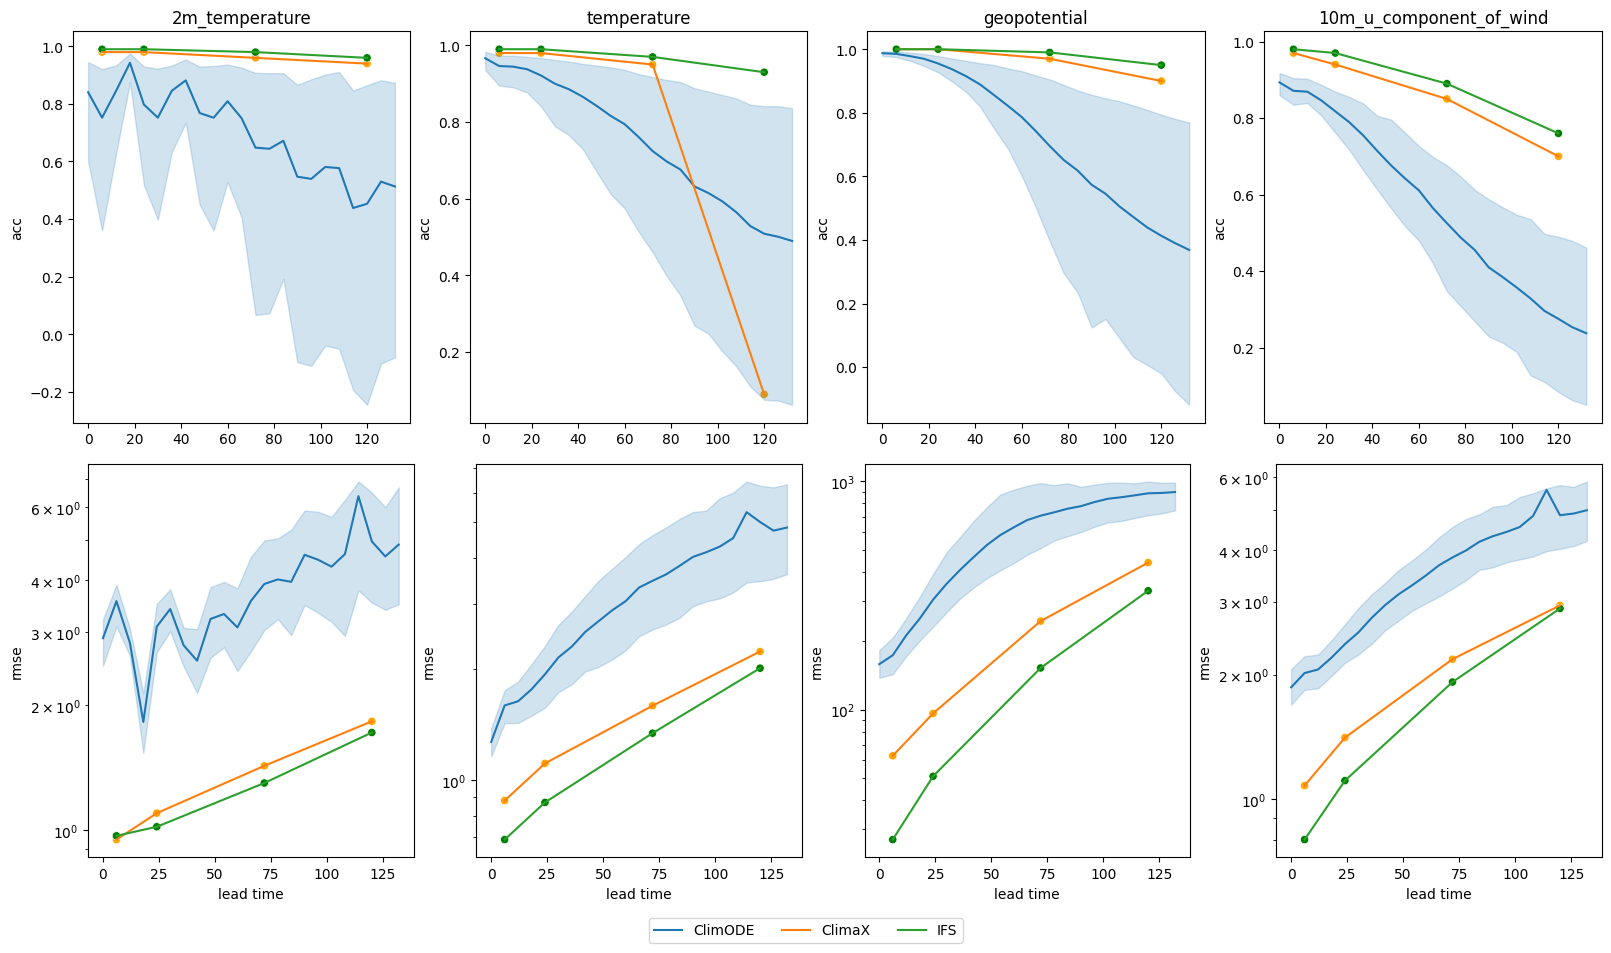

In [2]:
# Create the main figure and subfigures for each row
fig = plt.figure(constrained_layout=True, figsize=(8 * 2, 9))
subfigs = fig.subfigures(nrows=2, ncols=1)

# Titles for each column and row
column_titles = var_list

# Loop through each subfigure to create subplots
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=4)

    for col, ax in enumerate(axs):
        if row == 1:
            metric = "rmse"
            df = df_rmse
        else:
            metric = "acc"
            df = df_acc
        filters = df["variable"] == var_list[col]
        sns.scatterplot(
            data=df[(filters) & (df["model"] != "ClimODE")],
            x="lead time",
            y=metric,
            hue="model",
            ax=ax,
            legend=False,
            palette=["orange", "green"],
        )
        sns.lineplot(
            data=df[filters],
            x="lead time",
            y=metric,
            hue="model",
            errorbar="pi",
            ax=ax,
            legend=False,
        )

        # Add a title to the first subplot of each row to act as a column title
        if row == 0:
            ax.set_title(column_titles[col])
            ax.set_xlabel("")
        else:
            ax.set_yscale("log")
        if col == 0:
            ax.set_ylabel(metric)

# Optional: Create a shared legend for the figure
fig.legend(
    handles=axs[0].lines,
    labels=["ClimODE", "ClimaX", "IFS"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
)
# plt.tight_layout()
plt.savefig("./figs/acc_rmse.pdf", bbox_inches="tight", dpi=600)